## Created on Thr Aug 15 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

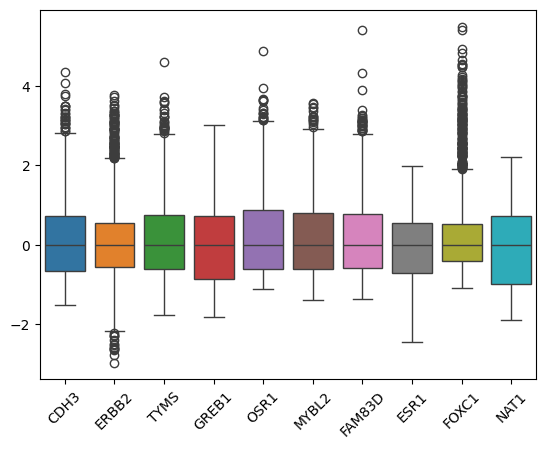

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("X_train_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

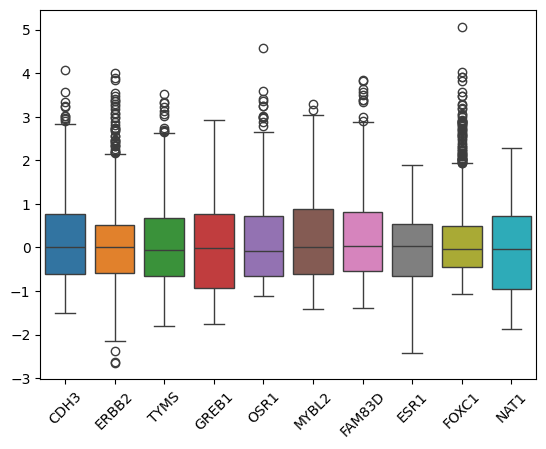

In [3]:
# Load X_test gene expression dataset.
X_test = pd.read_csv("X_test_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Test)
plt.rcdefaults()
sns.boxplot(X_test)
plt.xticks(rotation = 45)

In [4]:
# Load PAM50 subtype dataset.
target = pd.read_csv("GPL11154_PAM50.csv", sep = "\t", index_col = "geo_accession")
target.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [5]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [6]:
# Load test PAM50 subtype dataset.
y_test = target.loc[X_test.index.tolist(), :]
y_test.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2530931,LumB
GSM2528314,Basal
GSM2528222,Basal
GSM2531033,LumA
GSM2529552,LumB


In [7]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoder = encoder.transform(y_train)
y_test_encoder = encoder.transform(y_test)

# Create series.
y_train = pd.Series(y_train_encoder, index = y_train.index)
y_test = pd.Series(y_test_encoder, index = y_test.index)

In [8]:
# Downsampling based on k-means cluster,
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state = 42)
X_res, y_res = cc.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

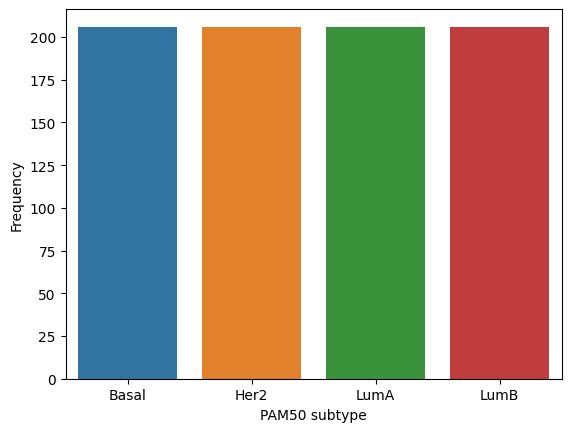

In [9]:
# Check count for each class in the training data.
class_counts = y_res.groupby(y_res).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

### Compare model performance between original and undersampled data.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
clf = LogisticRegression(random_state = 42, max_iter = 10000)
precision = make_scorer(precision_score, average = 'macro', zero_division = 0)
recall = make_scorer(recall_score, average = 'macro', zero_division = 0)

scoring = {"accuracy" : "accuracy",
           "precision" : precision,
           "recall" : recall,
           "f1-score" : "f1_macro",
           "auc" : "roc_auc_ovr"}

origianl_score = cross_validate(clf, X_train, y_train, cv = cv, scoring = scoring, return_train_score = True)
undersample_score = cross_validate(clf, X_res, y_res, cv = cv, scoring = scoring, return_train_score = True)

In [11]:
print("Mean train accuracy (original) =", np.mean(origianl_score["train_accuracy"]), "±", np.std(origianl_score["train_accuracy"]))
print("Mean validation accuracy (original) =", np.mean(origianl_score["test_accuracy"]), "±", np.std(origianl_score["test_accuracy"]), "\n")
print("Mean train precision (original) =", np.mean(origianl_score["train_precision"]), "±", np.std(origianl_score["train_precision"]))
print("Mean validation precision (original) =", np.mean(origianl_score["test_precision"]), "±", np.std(origianl_score["test_precision"]), "\n")
print("Mean train recall (original) =", np.mean(origianl_score["train_recall"]), "±", np.std(origianl_score["train_recall"]))
print("Mean validation recall (original) =", np.mean(origianl_score["test_recall"]), "±", np.std(origianl_score["test_recall"]), "\n")
print("Mean train F1-score (original) =", np.mean(origianl_score["train_f1-score"]), "±", np.std(origianl_score["train_f1-score"]))
print("Mean validation F1-score (original) =", np.mean(origianl_score["test_f1-score"]), "±", np.std(origianl_score["test_f1-score"]), "\n")
print("Mean train AUROC (original) =", np.mean(origianl_score["train_auc"]), "±", np.std(origianl_score["train_auc"]))
print("Mean validation AUROC (original) =", np.mean(origianl_score["test_auc"]), "±", np.std(origianl_score["test_auc"]), "\n")

Mean train accuracy (original) = 0.9101484358845598 ± 0.002969305245120093
Mean validation accuracy (original) = 0.9045422253084773 ± 0.01926523110254776 

Mean train precision (original) = 0.9105254537598877 ± 0.0035771762072324157
Mean validation precision (original) = 0.9044121552068779 ± 0.02437839702853413 

Mean train recall (original) = 0.8956694797159791 ± 0.0033713382911049923
Mean validation recall (original) = 0.8882674453177308 ± 0.0246098348251314 

Mean train F1-score (original) = 0.9027079991555023 ± 0.003375887127487839
Mean validation F1-score (original) = 0.894871051242236 ± 0.023284089008677362 

Mean train AUROC (original) = 0.9857504789091235 ± 0.0005214529055155901
Mean validation AUROC (original) = 0.9838202329006422 ± 0.005070913773746256 



In [12]:
print("Mean train accuracy (undersampled) =", np.mean(undersample_score["train_accuracy"]), "±", np.std(undersample_score["train_accuracy"]))
print("Mean validation accuracy (undersampled) =", np.mean(undersample_score["test_accuracy"]), "±", np.std(undersample_score["test_accuracy"]), "\n")
print("Mean train precision (undersampled) =", np.mean(undersample_score["train_precision"]), "±", np.std(undersample_score["train_precision"]))
print("Mean validation precision (undersampled) =", np.mean(undersample_score["test_precision"]), "±", np.std(undersample_score["test_precision"]), "\n")
print("Mean train recall (undersampled) =", np.mean(undersample_score["train_recall"]), "±", np.std(undersample_score["train_recall"]))
print("Mean validation recall (undersampled) =", np.mean(undersample_score["test_recall"]), "±", np.std(undersample_score["test_recall"]), "\n")
print("Mean train F1-score (undersampled) =", np.mean(undersample_score["train_f1-score"]), "±", np.std(undersample_score["train_f1-score"]))
print("Mean validation F1-score (undersampled) =", np.mean(undersample_score["test_f1-score"]), "±", np.std(undersample_score["test_f1-score"]), "\n")
print("Mean train AUROC (undersampled) =", np.mean(undersample_score["train_auc"]), "±", np.std(undersample_score["train_auc"]))
print("Mean validation AUROC (undersampled) =", np.mean(undersample_score["test_auc"]), "±", np.std(undersample_score["test_auc"]), "\n")

Mean train accuracy (undersampled) = 0.8942156734361302 ± 0.005310385051201747
Mean validation accuracy (undersampled) = 0.879138995004408 ± 0.036030553307787525 

Mean train precision (undersampled) = 0.8948931772959743 ± 0.005288870922226074
Mean validation precision (undersampled) = 0.8833640255294705 ± 0.035644833388591826 

Mean train recall (undersampled) = 0.8942151264167393 ± 0.005316875687773259
Mean validation recall (undersampled) = 0.8793214285714285 ± 0.03611409350147261 

Mean train F1-score (undersampled) = 0.8944493273107881 ± 0.005302897782870633
Mean validation F1-score (undersampled) = 0.8789736081874489 ± 0.0359925289330692 

Mean train AUROC (undersampled) = 0.9848068787020913 ± 0.0008898889968978266
Mean validation AUROC (undersampled) = 0.98048202743992 ± 0.009059338284196812 



### Hyperparameter tuning using GridSearchCV

In [13]:
hyperparameters = {'C' : [0.001, 0.01, 0.1, 1],
                   'l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9],
                   'class_weight' : [None, 'balanced'],
                   'penalty' : ['elasticnet'],
                   'solver' : ["saga"]}

optimizer = GridSearchCV(clf, hyperparameters, cv = cv, scoring = scoring, 
                         n_jobs = -1, return_train_score = True, refit = "accuracy")
best_model = optimizer.fit(X_train, y_train)

In [14]:
print('가장 좋은 C 값:', best_model.best_estimator_.get_params()['C'])
print('가장 좋은 l1 ratio:', best_model.best_estimator_.get_params()['l1_ratio'])
print('가장 좋은 class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('가장 좋은 penalty:', best_model.best_estimator_.get_params()['penalty'])
print('가장 좋은 solver:', best_model.best_estimator_.get_params()['solver'])
print("가장 좋은 Score :", best_model.best_score_)

가장 좋은 C 값: 1
가장 좋은 l1 ratio: 0.7
가장 좋은 class_weight: None
가장 좋은 penalty: elasticnet
가장 좋은 solver: saga
가장 좋은 Score : 0.9048002243469903


In [15]:
# Make GridSearCV result.
CV_result = pd.DataFrame(best_model.cv_results_)
select_columns = ['params',
                  'mean_train_accuracy', 'std_train_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
                  'mean_train_precision', 'std_train_precision', 'mean_test_precision', 'std_test_precision',
                  'mean_train_recall', 'std_train_recall', 'mean_test_recall', 'std_test_recall',
                  'mean_train_f1-score', 'std_train_f1-score', 'mean_test_f1-score', 'std_test_f1-score',
                  'mean_train_auc', 'std_train_auc', 'mean_test_auc', 'std_test_auc']

Final_GRID_result = CV_result.loc[:, select_columns].sort_values(by = 'mean_test_accuracy', ascending = False).reset_index(drop = True).transpose()
Final_GRID_result

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
params,"{'C': 1, 'class_weight': None, 'l1_ratio': 0.7...","{'C': 1, 'class_weight': None, 'l1_ratio': 0.1...","{'C': 1, 'class_weight': None, 'l1_ratio': 0.3...","{'C': 1, 'class_weight': None, 'l1_ratio': 0.5...","{'C': 1, 'class_weight': None, 'l1_ratio': 0.9...","{'C': 0.1, 'class_weight': None, 'l1_ratio': 0...","{'C': 0.1, 'class_weight': None, 'l1_ratio': 0...","{'C': 0.1, 'class_weight': None, 'l1_ratio': 0...","{'C': 0.1, 'class_weight': None, 'l1_ratio': 0...","{'C': 0.1, 'class_weight': None, 'l1_ratio': 0...",...,"{'C': 0.01, 'class_weight': None, 'l1_ratio': ...","{'C': 0.001, 'class_weight': 'balanced', 'l1_r...","{'C': 0.001, 'class_weight': None, 'l1_ratio':...","{'C': 0.001, 'class_weight': None, 'l1_ratio':...","{'C': 0.001, 'class_weight': None, 'l1_ratio':...","{'C': 0.001, 'class_weight': None, 'l1_ratio':...","{'C': 0.001, 'class_weight': None, 'l1_ratio':...","{'C': 0.001, 'class_weight': 'balanced', 'l1_r...","{'C': 0.001, 'class_weight': 'balanced', 'l1_r...","{'C': 0.001, 'class_weight': 'balanced', 'l1_r..."
mean_train_accuracy,0.910269,0.910148,0.910223,0.91036,0.910257,0.908429,0.908177,0.907455,0.905581,0.903501,...,0.837047,0.715621,0.652467,0.544307,0.542032,0.542032,0.542032,0.404675,0.344395,0.238349
std_train_accuracy,0.002999,0.00297,0.002987,0.003018,0.002936,0.002068,0.00212,0.002233,0.002309,0.002484,...,0.002587,0.006775,0.002417,0.000471,0.000186,0.000186,0.000186,0.065698,0.131396,0.170324
mean_test_accuracy,0.9048,0.904748,0.904697,0.904595,0.904542,0.904076,0.902683,0.90124,0.900053,0.898816,...,0.835177,0.71506,0.651933,0.544302,0.542033,0.542033,0.542033,0.404184,0.344902,0.238566
std_test_accuracy,0.019014,0.019071,0.018944,0.019082,0.01925,0.018946,0.019056,0.018247,0.018605,0.019234,...,0.023722,0.029322,0.015285,0.003341,0.001676,0.001676,0.001676,0.065686,0.131916,0.170187
mean_train_precision,0.910506,0.910543,0.910643,0.910741,0.910521,0.911914,0.911823,0.911112,0.908636,0.906031,...,0.882702,0.695845,0.716257,0.220216,0.135508,0.135508,0.135508,0.295905,0.181123,0.059587
std_train_precision,0.003619,0.003652,0.003622,0.003704,0.00353,0.00252,0.00258,0.002735,0.002692,0.002582,...,0.003088,0.005505,0.120727,0.011689,0.000047,0.000047,0.000047,0.035017,0.043692,0.042581
mean_test_precision,0.904048,0.904326,0.903996,0.903765,0.903942,0.908609,0.907178,0.905109,0.904027,0.902307,...,0.882077,0.698298,0.580209,0.197406,0.135508,0.135508,0.135508,0.297467,0.182105,0.059641
std_test_precision,0.023729,0.024414,0.02426,0.024112,0.023739,0.02271,0.022885,0.021623,0.022504,0.023303,...,0.026144,0.030657,0.088766,0.09151,0.000419,0.000419,0.000419,0.036301,0.045387,0.042547
mean_train_recall,0.895993,0.895689,0.895864,0.89611,0.89606,0.888301,0.887187,0.885232,0.881853,0.878634,...,0.763681,0.746458,0.445233,0.252366,0.25,0.25,0.25,0.547366,0.441728,0.25


### Model evaluation using hyperparameter

In [16]:
# Model fitting and prediction.
model = best_model.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [17]:
# Classification report
print(classification_report(y_test, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.95      0.89      0.92        92
        Her2       0.86      0.87      0.86        89
        LumA       0.93      0.92      0.92       450
        LumB       0.79      0.82      0.81       200

    accuracy                           0.89       831
   macro avg       0.88      0.88      0.88       831
weighted avg       0.89      0.89      0.89       831



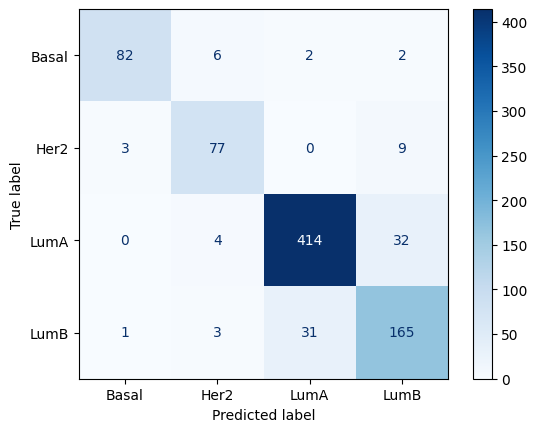

In [18]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

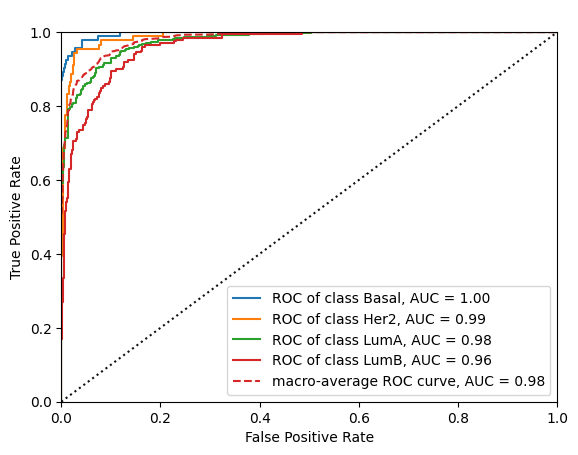

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [19]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

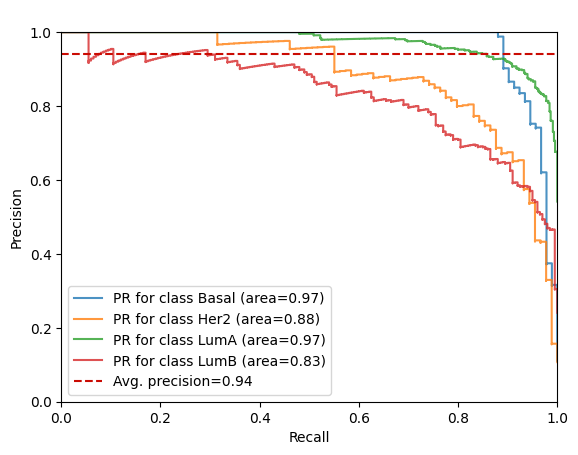

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [20]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, per_class = True, classes = ["Basal", "Her2", "LumA", "LumB"], title = " ")
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

In [21]:
# Accuracy
accuracy_score(y_test, y_pred)

0.8880866425992779

In [22]:
# Macro average precision
precision_score(y_test, y_pred, average = "macro")

0.8821219137655263

In [23]:
# Macro average recall
recall_score(y_test, y_pred, average = "macro")

0.8753682217879823

In [24]:
# Macro F1 score
f1_score(y_test, y_pred, average = "macro")

0.8783959906565388

In [25]:
# Macro average AUROC
roc_auc_score(y_test, y_pred_proba, multi_class = "ovr", average = "macro")

0.9813801098280334